In [1]:
# !cp -r /home/intern_lhj/stress_publish/WESAD/ ./

In [16]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from fffff import *
import random

In [4]:

subjects = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]

all_df_dict = dict()
print(f'loading train dataset')
for subject in tqdm(subjects):
    pkl = f'WESAD/S{subject}/S{subject}.pkl'
    all_df_dict[subject] = pickle.load(open(pkl, 'rb'), encoding = 'latin1')

loading train dataset


  0%|          | 0/15 [00:00<?, ?it/s]

In [5]:
all_df_dict[2].keys()

dict_keys(['signal', 'label', 'subject'])

In [6]:
all_df_dict[2]['signal']['chest'].keys(), all_df_dict[2]['signal']['wrist'].keys()

(dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']),
 dict_keys(['ACC', 'BVP', 'EDA', 'TEMP']))

In [7]:
ecg_label = dict()
for k, v in all_df_dict.items():
    ecg_label[k] = pd.DataFrame({'ecg' : v['signal']['chest']['ECG'].squeeze(), 'label' : v['label']})
    
for key in ecg_label.keys():
    ecg_label[key] = ecg_label[key][ecg_label[key]['label'].isin([1,2,3])]

<AxesSubplot: >

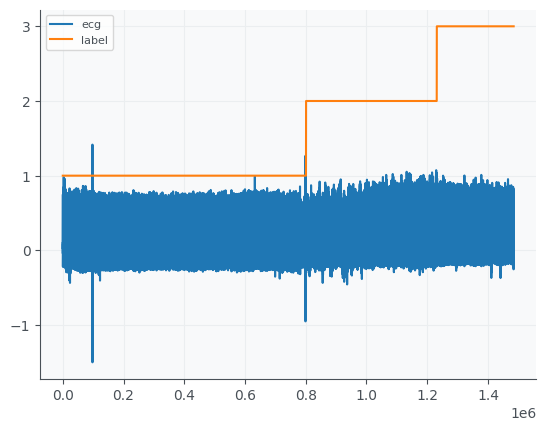

In [8]:
ecg_label[2].reset_index(drop = True).plot()

In [9]:
# baseline, stress, amusement

result_dict = dict()

for label in [1, 2]:
    for sec in [30, 20, 10]:
        hr = list()
        rmssd = list()
        sdnn = list()
        frequency_ratio = list()
        sdratio = list()
        for key, val in ecg_label.items():
            data = val[val['label'] == label]
            for i in range(0, len(data)-700*sec, sec*700):
                try:
                    rpeaks = nk_rpeaks(data['ecg'].iloc[i : i + sec*7000], 700)['rpeaks']
                    hrv_time = pyhrv_time(rpeaks, 700)
                    hr.append(hrv_time['pyhrv hr'])
                    rmssd.append(hrv_time['pyhrv rmssd'])        
                    sdnn.append(hrv_time['pyhrv sdnn'])       
                    nonlinear = pyhrv_nonlinear(rpeaks, 700)
                    sdratio.append(nonlinear['sd1/sd2'])
                    freqeuncy = pyhrv_welch(rpeaks, 700)
                    frequency_ratio.append(pyhrv_welch(rpeaks, 700)['fft_ratio'])
                except:
                    pass
                
            result_dict[f'{label}_{sec}_{key}'] = {
                'rmssd' : rmssd,
                'sdnn' : sdnn,
                'frequency_ratio' : frequency_ratio,
                'sdratio' : sdratio
            }


In [32]:
rr_dict = dict()

for sec in [30, 20, 10]:
    for key in [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]:
        for h in ['rmssd', 'sdnn', 'frequency_ratio', 'sdratio']:
            random.shuffle(result_dict[f'{1}_{sec}_{key}'][h])
            random.shuffle(result_dict[f'{2}_{sec}_{key}'][h])
            
            ll = len(result_dict[f'{2}_{sec}_{key}'][h])
            
            diff = np.array(result_dict[f'{2}_{sec}_{key}'][h]) - np.array(result_dict[f'{1}_{sec}_{key}'][h][:ll])
            
            rr_dict[f'{sec}_{key}_{h}'] = diff

In [36]:
np.concatenate((np.array([1,2,3]), np.array([1,2,3])))

array([1, 2, 3, 1, 2, 3])

In [44]:
rrr_dict = dict()
for sec in [30, 20, 10]:
    for h in ['rmssd', 'sdnn', 'frequency_ratio', 'sdratio']:
        temp = np.array([])
        for key in [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]:
            temp = np.concatenate((temp, rr_dict[f'{sec}_{key}_{h}']))
        rrr_dict[f'{sec}_{h}'] = {
            'mean' : np.mean(temp),
            'std' : np.std(temp)
        }
        
pd.DataFrame(rrr_dict).T.

,mean,std
30_rmssd,-7.794584,44.496188
30_sdnn,-3.476639,40.250843
30_frequency_ratio,0.583435,4.115850
30_sdratio,-0.054556,0.223829
20_rmssd,-7.872198,46.161091
20_sdnn,-4.131407,40.635492
20_frequency_ratio,0.783209,4.962890
20_sdratio,-0.057154,0.231635
10_rmssd,-9.185832,48.372172
10_sdnn,-5.687723,41.290623
